In [16]:
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

quantity_support()

%matplotlib widget

In [17]:
# all length units mm

f = 85.
d = f / 1.4
# f = 200
# d = f / 2.8

theta_exclude = 10. * u.deg # notional
# theta_exclude = 5 * u.deg
fov_diag = 11.31 * u.deg # actual, given newer proposed TIM sensor
# fov_diag = 3.84 * u.deg
theta_fov = fov_diag / 2.
assert(theta_exclude > theta_fov) # baffle does not vignette lens

# for really wide FoV baffles, may be beneficial to be cone-shaped rather than straight
# the tradeoff is more vanes required, esp. if rb is small
mode = 'straight' # 'straight' or 'cone'
# mode = 'cone'

# baffle min height
rb = 25.4 / 1 # free parameter
if mode == 'cone':
    rb *= 4 # results in fewer baffles, better for cone shape

frac = np.tan(theta_exclude) / np.tan(theta_fov)
# baffle tube diam
D = -d * (1 + frac) / (1 - frac)
# baffle tube length
L = (D / 2 + d / 2) / np.tan(theta_exclude)
D, L, rb

(<Quantity 216.24858706>, <Quantity 785.36725254>, 25.4)

In [18]:
# setup for solving for lots of intersections
p0 = [1,]

def slope(x0, x1, y0, y1):
    m = (y1 - y0) / (x1 - x0)
    return m
def intercept(x, y, m):
    b = y - m * x
    return b
def y(x0, x1, y0, y1):
    m = slope(x0, x1, y0, y1)
    b = intercept(x0, y0, m)
    return lambda x: m * x + b
def func(pts0, pts1):
    x0, x1, y0, y1 = pts0
    xp0, xp1, yp0, yp1 = pts1
    return lambda x: y(x0, x1, y0, y1)(x) - y(xp0, xp1, yp0, yp1)(x)

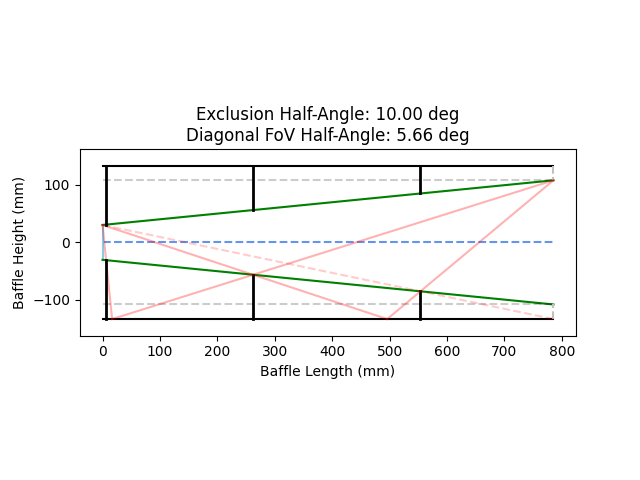

In [19]:
lcolor = 'skyblue'
bcolor = 'k'

fig, ax = plt.subplots()
ax.set_ylim(-D/2 * 1.5, D/2 * 1.5)
# optical axis
ax.plot([0, L], [0, 0], linestyle='--', color='cornflowerblue')
# objective
ax.plot([0, 0], [-d/2, d/2], color=lcolor)
# marginal ray due to FOV
marginal_ray = [0, L, -d/2, -D/2]
mray_func = y(*marginal_ray)
ax.plot(marginal_ray[:2], marginal_ray[2:], color='g')
ax.plot(marginal_ray[:2], -np.array(marginal_ray[2:]), color='g')
# height of smallest baffle, limits off-axis light
ax.plot([0, L], [-D/2, -D/2], linestyle='--', color=bcolor, alpha=0.2)
ax.plot([0, L], -np.array([-D/2, -D/2]), linestyle='--', color=bcolor, alpha=0.2)
# outer edge of tube
if mode == 'cone':
    baffle_wall = [0, L, -d/2-rb, -D/2-rb]
else:
    baffle_wall = [0, L, -D/2-rb, -D/2-rb]
baffle_wall_func = y(*baffle_wall)
ax.plot(baffle_wall[:2], baffle_wall[2:], color=bcolor)
ax.plot(baffle_wall[:2], -np.array(baffle_wall[2:]), color=bcolor)
# first baffle
ax.plot([L, L], [-D/2-rb, -D/2], linestyle='--', color='silver')
ax.plot([L, L], -np.array([-D/2-rb, -D/2]), linestyle='--', color='silver')
# critical ray from inside of baffle tube to objective
critical_ray = [0, L, d/2, -D/2-rb]
ax.plot(critical_ray[:2], critical_ray[2:], linestyle='--', color='r', alpha=0.2)

x_wall = L
x_baffle = L
nfev = 100
x_baffles = []
y_baffles = []
while nfev > 0:
    nfev -= 1
    # find the intersection of a critical ray with the lower baffle tube
    x_baffle = fsolve(func(marginal_ray, critical_ray), p0)[0]
    y_baffle = mray_func(x_baffle)
    x_baffles.append(x_baffle)
    y_baffles.append(y_baffle)
    ax.plot([x_baffle, x_baffle], [-D/2-rb, y_baffle], linewidth=2, color=bcolor)
    ax.plot([x_baffle, x_baffle], -np.array([-D/2-rb, y_baffle]), linewidth=2, color=bcolor)
    # find point where of an off-axis ray may illuminate the baffle wall
    off_axis_ray = [L, x_baffle, D/2, y_baffle]
    x_wall = fsolve(func(off_axis_ray, baffle_wall), p0)[0]
    if x_wall < 0:
        break
    # incident illuminating off-axis ray
    critical_ray = [0, x_wall, d/2, baffle_wall_func(x_wall)]
    ax.plot([L, x_wall], [D/2, baffle_wall_func(x_wall)], color='r', alpha=0.3)
    # critical ray to illuminated point
    ax.plot([0, x_wall], [d/2, baffle_wall_func(x_wall)], color='r', alpha=0.3)
ax.set_aspect('equal')
ax.set_xlabel('Baffle Length (mm)')
ax.set_ylabel('Baffle Height (mm)')
ax.set_title(f'Exclusion Half-Angle: {theta_exclude:.2f}\nDiagonal FoV Half-Angle: {theta_fov:.2f}');

In [20]:
print('Baffle Locations:', x_baffles[::-1])
print('Baffle Spacings:', np.diff(x_baffles[::-1]))
print('Baffle Radii:', -np.array(y_baffles)[::-1])
print('Total Tube Diam.:', D + 2 * rb)
print('Total Tube Length:', L)

Baffle Locations: [6.232662655352687, 262.23765140541224, 553.7177875412449]
Baffle Spacings: [256.00498875 291.48013614]
Baffle Radii: [30.97430179 56.32394359 85.18633834]
Total Tube Diam.: 267.0485870613765
Total Tube Length: 785.3672525408529
